In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries

In [53]:
import numpy as np
import matplotlib as mpl
from time import time 
import time as tm
import tensorflow as tf
from keras.layers import Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, SpatialDropout2D, Concatenate, Conv2D, MaxPooling2D
tf.keras.layers.Concatenate()
from keras import optimizers
from keras import Input, Model
from keras import backend as K

# Filters

In [54]:
################################################## 30 SRM FILTERS
srm_weights = np.load('drive/My Drive/SIMPA_ICTAS2023/SRM.npy') 
biasSRM=np.ones(30)
#print (srm_weights.shape)
################################################## TANH ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################

### proposed_Jean_emelard architecture

In [55]:
def SIMPA_Jean_ICTAS2023(img_size=256):
    model = tf.keras.Sequential() 
    
    model.add(tf.keras.layers.Conv2D(30, (3, 3), input_shape=(256, 256, 1), strides=(1, 1), padding='valid', activation='relu'))
    model.add(tf.keras.layers.Conv2D(30, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None))
    print(model.output_shape)

    model.add(tf.keras.layers.AveragePooling2D(pool_size=(5, 5), strides=(2, 2), padding='valid'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None))
    print(model.output_shape)

    model.add(tf.keras.layers.AveragePooling2D(pool_size=(5, 5), strides=(2, 2), padding='valid'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None))
    print(model.output_shape)

    model.add(tf.keras.layers.AveragePooling2D(pool_size=(5, 5), strides=(2, 2), padding='valid'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None))
    print(model.output_shape)

    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='valid', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None))
    print(model.output_shape)

    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))  

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
model = SIMPA_Jean_ICTAS2023()
model.summary()


(None, 252, 252, 30)
(None, 122, 122, 32)
(None, 57, 57, 32)
(None, 25, 25, 128)
(None, 10, 10, 128)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_162 (Conv2D)         (None, 254, 254, 30)      300       
                                                                 
 conv2d_163 (Conv2D)         (None, 252, 252, 30)      8130      
                                                                 
 batch_normalization_135 (Ba  (None, 252, 252, 30)     90        
 tchNormalization)                                               
                                                                 
 average_pooling2d_135 (Aver  (None, 124, 124, 30)     0         
 agePooling2D)                                                   
                                                                 
 conv2d_164 (Conv2D)         (None, 122, 122, 32)      8672      
                  

# Functions to interact with the architecture

In [56]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve

def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, initial_epoch=0, model_name=""):
    start_time = time.time()
    log_dir = "/drive/My Drive/SIMPA_ICTAS2023/trained_models/" + model_name + "_" + str(int(time.time()))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    filepath = log_dir + "/saved-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    history = model.fit(X_train, y_train, epochs=epochs, callbacks=[tensorboard, checkpoint],
                        batch_size=batch_size, validation_data=(X_valid, y_valid), initial_epoch=initial_epoch)

    metrics = model.evaluate(X_test, y_test, verbose=0)
    results_dir = "/drive/My Drive/SIMPA_ICTAS2023/Results/" + model_name + "/"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Accuracy Vs Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid(True)
        plt.savefig(results_dir + 'Accuracy_SIMPA_Jean_ICTAS2023_' + model_name + '.eps', format='eps')
        plt.savefig(results_dir + 'Accuracy_SIMPA_Jean_ICTAS2023_' + model_name + '.svg', format='svg')
        plt.savefig(results_dir + 'Accuracy_SIMPA_Jean_ICTAS2023_' + model_name + '.pdf', format='pdf')
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss Vs Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid(True)
        plt.savefig(results_dir + 'Loss_SIMPA_Jean_ICTAS2023_' + model_name + '.eps', format='eps')
        plt.savefig(results_dir + 'Loss_SIMPA_Jean_ICTAS2023_' + model_name + '.svg', format='svg')
        plt.savefig(results_dir + 'Loss_SIMPA_Jean_ICTAS2023_' + model_name + '.pdf', format='pdf')
        plt.show()

    elapsed_time = time.time() - start_time
    print("Time " + model_name + " = %s [seconds]" % elapsed_time)
    return {k: v for k, v in zip(model.metrics_names, metrics)}

def Final_Results_Test(model, Trained_Models):
    best_accuracy = 0  # B --> Best
    for filename in os.listdir(Trained_Models):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model.load_weights(Trained_Models+'/'+filename)
            loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_loss = loss
                best_name = filename
    print("\n\nBest")
    print(best_name)
    print(f'Loss={best_loss:.4f} y Accuracy={best_accuracy:0.4f}'+'\n')

############################################################################
from tqdm import tqdm

def plot_train_valid(model,PATH_trained_models,model_name):
    acc_train=[]
    acc_valid=[]
    loss_train=[]
    loss_valid=[]
    for filename in tqdm(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model.load_weights(PATH_trained_models+'/'+filename)
            loss,accuracy = model.evaluate(X_train, y_train,verbose=0)
            acc_train.append(accuracy)
            loss_train.append(loss)
            loss,accuracy = model.evaluate(X_valid, y_valid,verbose=0)
            acc_valid.append(accuracy)
            loss_valid.append(loss)

    results_dir="/drive/My Drive/SIMPA_ICTAS2023/Results/"+model_name+"/"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        #plt.subplot(1,2,1)
        #Plot training & validation accuracy values
        plt.plot(acc_train)
        plt.plot(acc_valid)
        plt.title('Accuracy Vs Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'SIMPA_Jean_ICTAS2023_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'SIMPA_Jean_ICTAS2023_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'SIMPA_Jean_ICTAS2023_'+model_name+'.pdf', format='pdf')
        plt.show()

        plt.figure(figsize=(5, 5))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(loss_train)
        plt.plot(loss_valid)
        plt.title('Loss Vs Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'SIMPA_Jean_ICTAS2023_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'SIMPA_Jean_ICTAS2023_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'SIMPA_Jean_ICTAS2023_'+model_name+'.pdf', format='pdf')
        plt.show()
    results={'acc_train':acc_train,'acc_valid':acc_valid,'loss_train':loss_train,'loss_valid':loss_valid}
    return results

############################################################################################
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
)

def get_curve(gt, pred, target_names, model_name):
    labels = []
    for i in range(len(target_names)):
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = model_name + target_names[i] + " AUC: %.3f " % auc_roc
        labels.append(label)
        xlabel = "False positive rate (FPR)"
        ylabel = "True positive rate (TPR)"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(5, 5))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                  fancybox=True, ncol=1)

    return [a, b], labels
labels = ["cover_image","stego_image"]

# Model training (WOW-0.05 bpp)

In [57]:
#Train
X_train = np.load('drive/My Drive/SIMPA_ICTAS2023/X_train.npy')
y_train = np.load('drive/My Drive/SIMPA_ICTAS2023/y_train.npy')
#Valid
X_valid = np.load('drive/My Drive/SIMPA_ICTAS2023/X_valid.npy')
y_valid = np.load('drive/My Drive/SIMPA_ICTAS2023/y_valid.npy')
#Test
X_test = np.load('drive/My Drive/SIMPA_ICTAS2023/X_test.npy')
y_test = np.load('drive/My Drive/SIMPA_ICTAS2023/y_test.npy')

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)


(50, 256, 256)
(50, 2)
(30, 256, 256)
(30, 2)
(20, 256, 256)
(20, 2)


## CNN name and algorithm 

In [58]:
base_name="SIMPA_Jean_ICTAS2023"
m_name="SIMPA_Jean_ICTAS2023"

## Training

(None, 252, 252, 30)
(None, 122, 122, 32)
(None, 57, 57, 32)
(None, 25, 25, 128)
(None, 10, 10, 128)
Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 1.6348 - accuracy: 0.3600 - val_loss: 1.1070 - val_accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - 0s 364ms/step - loss: 0.6684 - accuracy: 0.8400 - val_loss: 3.2211 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 1s 958ms/step - loss: 0.2375 - accuracy: 0.9400 - val_loss: 3.2805 - val_accuracy: 0.5333
Epoch 4/10
1/1 [==============================] - 1s 570ms/step - loss: 0.1202 - accuracy: 0.9600 - val_loss: 2.0899 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 413ms/step - loss: 0.0536 - accuracy: 1.0000 - val_loss: 1.1946 - val_accuracy: 0.6333
Epoch 6/10
1/1 [==============================] - 1s 515ms/step - loss: 0.0471 - accuracy: 1.0000 - val_loss: 1.1549 - val_accuracy: 0.7333
Epoch 7/10
1/1 [==============================] - 0s 287ms/ste

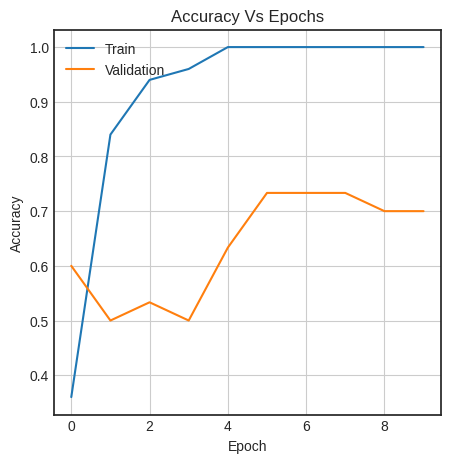

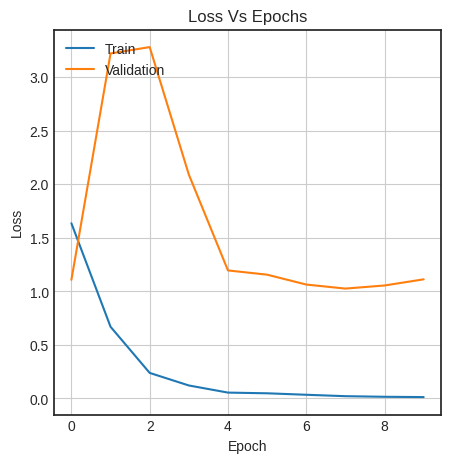

Time Model_SIMPA_Jean_ICTAS2023_SIMPA_Jean_ICTAS2023 = 10.74101996421814 [seconds]


In [59]:
model= SIMPA_Jean_ICTAS2023() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=10, model_name=name)

#Testing

In [60]:
model= SIMPA_Jean_ICTAS2023() 
PATH_trained_models = 'drive/My Drive/SIMPA_ICTAS2023/trained_models'
Final_Results_Test(SIMPA_Jean_ICTAS2023(),'drive/My Drive/SIMPA_ICTAS2023/trained_models/Model_SIMPA_Jean_ICTAS2023_SIMPA_Jean_ICTAS2023_1686052199')

(None, 252, 252, 30)
(None, 122, 122, 32)
(None, 57, 57, 32)
(None, 25, 25, 128)
(None, 10, 10, 128)
(None, 252, 252, 30)
(None, 122, 122, 32)
(None, 57, 57, 32)
(None, 25, 25, 128)
(None, 10, 10, 128)
saved-model-01-0.50.hdf5
Loss=1.8880 y Accuracy=0.5000

saved-model-02-0.50.hdf5
Loss=7.3925 y Accuracy=0.5000

saved-model-03-0.50.hdf5
Loss=9.8011 y Accuracy=0.5000

saved-model-04-0.50.hdf5
Loss=4.8987 y Accuracy=0.5000

saved-model-05-0.50.hdf5
Loss=5.2378 y Accuracy=0.4500



Best
saved-model-01-0.50.hdf5
Loss=1.8880 y Accuracy=0.5000



# Training, validation and testing graph

(None, 252, 252, 30)
(None, 122, 122, 32)
(None, 57, 57, 32)
(None, 25, 25, 128)
(None, 10, 10, 128)
(None, 252, 252, 30)
(None, 122, 122, 32)
(None, 57, 57, 32)
(None, 25, 25, 128)
(None, 10, 10, 128)


  0%|          | 0/7 [00:00<?, ?it/s]

saved-model-01-0.50.hdf5


 43%|████▎     | 3/7 [00:00<00:00,  5.46it/s]

saved-model-02-0.50.hdf5


 57%|█████▋    | 4/7 [00:00<00:00,  4.83it/s]

saved-model-03-0.50.hdf5


 71%|███████▏  | 5/7 [00:01<00:00,  4.55it/s]

saved-model-04-0.50.hdf5


 86%|████████▌ | 6/7 [00:01<00:00,  4.48it/s]

saved-model-05-0.50.hdf5


100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


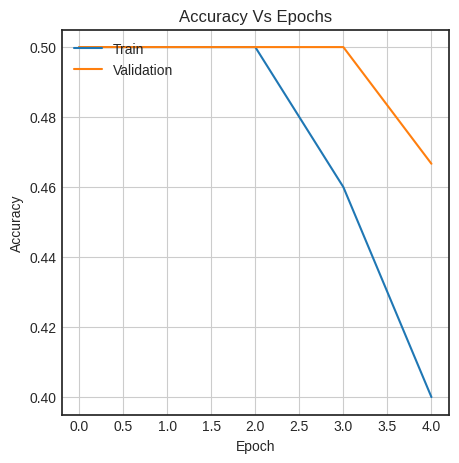

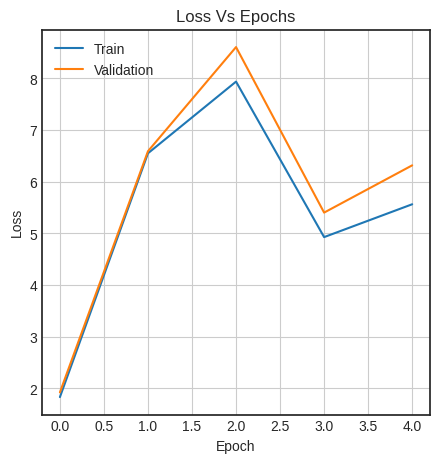

In [61]:
model= SIMPA_Jean_ICTAS2023()  
PATH_trained_models = 'drive/My Drive/SIMPA_ICTAS2023/trained_models/Model_SIMPA_Jean_ICTAS2023_SIMPA_Jean_ICTAS2023_1686052199'
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(SIMPA_Jean_ICTAS2023(),PATH_trained_models,name)

#ROC Curve

(None, 252, 252, 30)
(None, 122, 122, 32)
(None, 57, 57, 32)
(None, 25, 25, 128)
(None, 10, 10, 128)


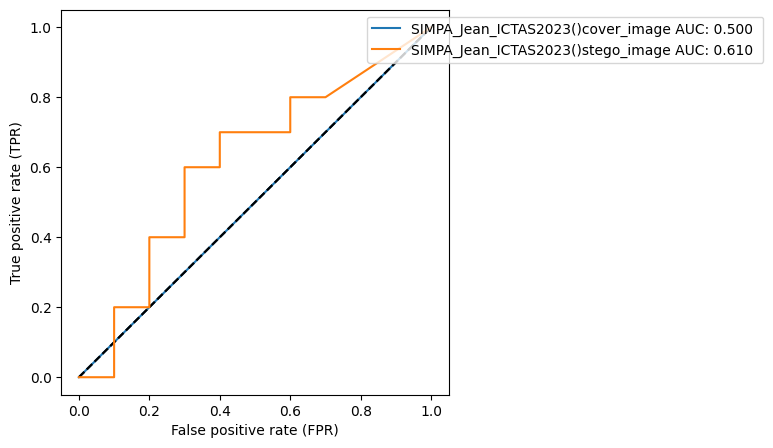

In [68]:
model= SIMPA_Jean_ICTAS2023() 
model.load_weights('drive/MyDrive/emelard/trained_models/Model_SIMPA_Jean_ICTAS2023_SIMPA_Jean_ICTAS2023_1686041888.2829206/saved-model-05-0.50.hdf5') #path best model
predictions= model.predict(X_test,verbose=0)
labels = ["cover_image","stego_image"]
model_name="SIMPA_Jean_ICTAS2023()"
curve1,labels1=get_curve(y_test, predictions, labels,model_name)

#END